In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Goal
- Predict House seat share and vote share of the Republican party (national level)
Factors:

# Incumbency
- Is midterm year
- Party of the president
<!-- - Is the incumbent president running -->
- \# of existing R/D seats
- Prior party vote share

# Economy
- Consumer sentiment (absolute and change)
- RDI, GDP

# Polling
- Presidential Approval
- Generic Congressional Ballot

In [2]:
results_df = pd.read_csv("lite_data/incumb_dist_1948-2022 (2).csv")
results_df.head()

,Unnamed: 0,office,year,state,st_fips,district_num,district_id,winner_party,RepVotes,RepCandidate,RepStatus,DemVotes,DemCandidate,DemStatus,RepVotesMajorPercent,DemVotesMajorPercent,winner_candidate,winner_candidate_inc,st_cd_fips
0,1,House,2020,Alabama,1,1,AL01,R,211825,"Carl, Jerry",Challenger,116949,"Averhart, James",Challenger,64.43,35.57,RepCandidate,Challenger,101
1,2,House,2020,Alabama,1,2,AL02,R,197996,"Moore, Barry",Challenger,105286,"Harvey-Hall, Phyllis",Challenger,65.28,34.72,RepCandidate,Challenger,102
2,3,House,2020,Alabama,1,3,AL03,R,217384,"Rogers, Mike D.",Incumbent,104595,"Winfrey, Adia McClellan",Challenger,67.51,32.49,RepCandidate,Incumbent,103
3,4,House,2020,Alabama,1,4,AL04,R,261553,"Aderholt, Robert",Incumbent,56237,"Neighbors, Rick",Challenger,82.30,17.70,RepCandidate,Incumbent,104
4,5,House,2020,Alabama,1,5,AL05,R,253094,"Brooks, Mo",Incumbent,0,NaN,NaN,100.00,0.00,RepCandidate,Incumbent,105


In [3]:
results_df.groupby(["year"])["winner_party"].value_counts().reset_index(name="count")

,year,winner_party,count
0,1948,D,256
1,1948,R,177
2,1950,D,226
3,1950,R,207
4,1952,R,230
...,...,...,...
69,2016,D,195
70,2018,D,235
71,2018,R,201
72,2020,D,222


In [4]:
party_results_df = results_df.drop_duplicates(subset=["year", "district_id"], keep="first").groupby(["year"])["winner_party"].value_counts().reset_index(name="count")
party_results_df.tail()

,year,winner_party,count
69,2016,D,194
70,2018,D,234
71,2018,R,201
72,2020,D,222
73,2020,R,213


In [5]:
# Create columns for Democrat and Republican party seats for each election year

party_results_df["dem_seats"] = np.where(party_results_df["winner_party"] == "D", party_results_df["count"], 0)
party_results_df["rep_seats"] = np.where(party_results_df["winner_party"] == "R", party_results_df["count"], 0)
party_seat_counts = party_results_df.groupby(["year"])["dem_seats", "rep_seats"].sum().reset_index()
party_seat_counts["RepSeatShare"] = party_seat_counts["rep_seats"] / (party_seat_counts["dem_seats"] + party_seat_counts["rep_seats"])
new_results_df = party_seat_counts[["year", "RepSeatShare"]]
new_results_df.tail()

<ipython-input-5-b879b9148ead>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  party_seat_counts = party_results_df.groupby(["year"])["dem_seats", "rep_seats"].sum().reset_index()


,year,RepSeatShare
32,2012,0.537931
33,2014,0.565517
34,2016,0.554023
35,2018,0.462069
36,2020,0.489655


In [6]:
new_results_df["is_midterm_year"] = np.where((new_results_df["year"] % 2 == 0) & (new_results_df["year"] % 4 != 0), 1, 0)
new_results_df.tail()

<ipython-input-6-069abb52ea37>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_results_df["is_midterm_year"] = np.where((new_results_df["year"] % 2 == 0) & (new_results_df["year"] % 4 != 0), 1, 0)


,year,RepSeatShare,is_midterm_year
32,2012,0.537931,0
33,2014,0.565517,1
34,2016,0.554023,0
35,2018,0.462069,1
36,2020,0.489655,0


In [7]:
# wiki_president = pd.read_html("https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States")
wiki_president = pd.read_html("lite_data/List of presidents of the United States - Wikipedia.html")

In [8]:
pres_info = {}
pres_info["year"] = []
pres_info["rep_pres"] = []

for year in range(1944, 2022, 4):
    mini_df = wiki_president[0][["Party[b][16].1", "Election"]]
    # print(year, list(mini_df[mini_df["Election"].str.contains(str(year))]["Party[b][16].1"])[0])
    pres_info["year"].append(year)
    pres_info["rep_pres"].append(list(mini_df[mini_df["Election"].str.contains(str(year))]["Party[b][16].1"])[0] == "Republican")

In [9]:
pres_df = pd.DataFrame(pres_info)

pres_df["year"] = pres_df["year"] + 4

pres_df.tail()

,year,rep_pres
15,2008,True
16,2012,False
17,2016,False
18,2020,True
19,2024,False


In [10]:
new_results_df = pd.merge(new_results_df, pres_df, on="year", how="left").fillna(method="bfill")

In [11]:
new_results_df

,year,RepSeatShare,is_midterm_year,rep_pres
0,1948,0.408776,0,False
1,1950,0.478060,1,False
2,1952,0.531178,0,False
3,1954,0.480370,1,True
4,1956,0.482679,0,True
5,1958,0.374134,1,True
6,1960,0.404598,0,True
7,1962,0.424883,1,False
8,1964,0.332564,0,False
9,1966,0.438799,1,False


In [12]:
# Create a column for prior seat share for each election year

new_results_df["RepSeatShare_prior"] = new_results_df["RepSeatShare"].shift(1)

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior
32,2012,0.537931,0,False,0.555819
33,2014,0.565517,1,False,0.537931
34,2016,0.554023,0,False,0.565517
35,2018,0.462069,1,True,0.554023
36,2020,0.489655,0,True,0.462069


In [13]:
party_votes = results_df.groupby("year")[["RepVotes", "DemVotes"]].sum().reset_index()

party_votes["RepVoteShare"] = party_votes["RepVotes"] / (party_votes["RepVotes"] + party_votes["DemVotes"])

party_votes["RepVoteShare_prior"] = party_votes["RepVoteShare"].shift(1)


In [14]:
new_results_df = pd.merge(new_results_df, party_votes[["year", "RepVoteShare", "RepVoteShare_prior"]], on="year", how="left")

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior
32,2012,0.537931,0,False,0.555819,0.495409,0.534744
33,2014,0.565517,1,False,0.537931,0.529084,0.495409
34,2016,0.554023,0,False,0.565517,0.507205,0.529084
35,2018,0.462069,1,True,0.554023,0.457170,0.507205
36,2020,0.489655,0,True,0.462069,0.487428,0.457170


In [15]:
from fredapi import Fred

In [16]:
fred = Fred(api_key="3d5ebdf0ee34ff119c3b4515e60188e3")

In [17]:
sentiment_data = fred.get_series("UMCSENT")

In [18]:
sentiment_data.head()

1952-11-01    86.2
1952-12-01     NaN
1953-01-01     NaN
1953-02-01    90.7
1953-03-01     NaN
dtype: float64

In [19]:
consumer_data = {}
consumer_data["year"] = []
consumer_data["absolute_sentiment"] = []
consumer_data["sentiment_change"] = []

for year in range(1948, 2022, 2):

    consumer_data["year"].append(year)
    consumer_data["absolute_sentiment"].append(sentiment_data[(sentiment_data.index.year == year) & (sentiment_data.index.month == 11)].mean())
    consumer_data["sentiment_change"].append(sentiment_data[(sentiment_data.index.year == year) & (sentiment_data.index.month == 11)].mean() - sentiment_data[(sentiment_data.index.year == year - 1) & (sentiment_data.index.month == 1)].mean())

consumer_df = pd.DataFrame(consumer_data)
consumer_df.tail()

,year,absolute_sentiment,sentiment_change
32,2012,82.7,8.5
33,2014,88.8,15.0
34,2016,93.8,-4.3
35,2018,97.5,-1.0
36,2020,76.9,-14.3


In [20]:
new_results_df = pd.merge(new_results_df, consumer_df, on="year", how="left")

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior,absolute_sentiment,sentiment_change
32,2012,0.537931,0,False,0.555819,0.495409,0.534744,82.7,8.5
33,2014,0.565517,1,False,0.537931,0.529084,0.495409,88.8,15.0
34,2016,0.554023,0,False,0.565517,0.507205,0.529084,93.8,-4.3
35,2018,0.462069,1,True,0.554023,0.457170,0.507205,97.5,-1.0
36,2020,0.489655,0,True,0.462069,0.487428,0.457170,76.9,-14.3


In [21]:
gdp_data = fred.get_series("A191RL1Q225SBEA")
real_gdp = fred.get_series("A191RL1Q225SBEA")
    

In [22]:
absolute_gdp = {}
absolute_gdp["year"] = []
absolute_gdp["absolute_gdp"] = []
absolute_gdp["gdp_change"] = []

for year in range(1948, 2022, 2):

    absolute_gdp["year"].append(year)
    absolute_gdp["absolute_gdp"].append(gdp_data[(gdp_data.index.year == year) & (gdp_data.index.month == 10)].mean())
    absolute_gdp["gdp_change"].append(real_gdp.pct_change(6)[(real_gdp.pct_change(6).index.year == year) & (real_gdp.pct_change(6).index.month == 10)].mean())

gdp_df = pd.DataFrame(absolute_gdp)

gdp_df.tail()

,year,absolute_gdp,gdp_change
32,2012,0.4,-0.851852
33,2014,1.8,2.000000
34,2016,2.0,-0.130435
35,2018,0.7,-0.650000
36,2020,3.9,0.444444


In [23]:
new_results_df = pd.merge(new_results_df, gdp_df, on="year", how="left")

In [24]:
new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change
32,2012,0.537931,0,False,0.555819,0.495409,0.534744,82.7,8.5,0.4,-0.851852
33,2014,0.565517,1,False,0.537931,0.529084,0.495409,88.8,15.0,1.8,2.000000
34,2016,0.554023,0,False,0.565517,0.507205,0.529084,93.8,-4.3,2.0,-0.130435
35,2018,0.462069,1,True,0.554023,0.457170,0.507205,97.5,-1.0,0.7,-0.650000
36,2020,0.489655,0,True,0.462069,0.487428,0.457170,76.9,-14.3,3.9,0.444444


In [25]:
rdi_data = fred.get_series("A229RX0")

In [26]:
rdi_info = {}
rdi_info["year"] = []
rdi_info["rdi"] = []
rdi_info["rdi_change"] = []

for year in range(1948, 2022, 2):

    rdi_info["year"].append(year)
    rdi_info["rdi"].append( rdi_data.pct_change(12)[(rdi_data.pct_change(12).index.year == year) & (rdi_data.pct_change(12).index.month == 11)].mean())
    rdi_info["rdi_change"].append( rdi_data.pct_change(12)[(rdi_data.pct_change(22).index.year == year) & (rdi_data.pct_change(12).index.month == 11)].mean())

rdi_df = pd.DataFrame(rdi_info)

rdi_df.tail()
   

,year,rdi,rdi_change
32,2012,0.040656,0.040656
33,2014,0.042901,0.042901
34,2016,0.010259,0.010259
35,2018,0.031813,0.031813
36,2020,0.026635,0.026635


In [27]:
new_results_df = pd.merge(new_results_df, rdi_df, on="year", how="left")

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change,rdi,rdi_change
32,2012,0.537931,0,False,0.555819,0.495409,0.534744,82.7,8.5,0.4,-0.851852,0.040656,0.040656
33,2014,0.565517,1,False,0.537931,0.529084,0.495409,88.8,15.0,1.8,2.000000,0.042901,0.042901
34,2016,0.554023,0,False,0.565517,0.507205,0.529084,93.8,-4.3,2.0,-0.130435,0.010259,0.010259
35,2018,0.462069,1,True,0.554023,0.457170,0.507205,97.5,-1.0,0.7,-0.650000,0.031813,0.031813
36,2020,0.489655,0,True,0.462069,0.487428,0.457170,76.9,-14.3,3.9,0.444444,0.026635,0.026635


In [28]:
# xls = pd.ExcelFile("American Presidency Project - Approval Ratings for POTUS.xlsx")

In [29]:
# polls_dfs = []
# for sheet_name in xls.sheet_names:
#     polls_dfs.append(pd.read_excel(xls, sheet_name))

# polls_df = pd.concat(polls_dfs)
# polls_df.head()

In [30]:
# polls_info = {}
# polls_info["year"] = []
# polls_info["annual_poll_approval"] = []
# polls_info["two_month_poll_approval"] = []
# polls_info["annual_poll_disapproval"] = []
# polls_info["two_month_poll_disapproval"] = []

# for year in range(1948, 2022, 2):

#     polls_info["year"].append(year)
#     polls_info["annual_poll_approval"].append(polls_df[(polls_df["Start Date"].dt.year == year) & (polls_df["Start Date"].dt.month <= 11)]["Approving"].mean())
#     polls_info["two_month_poll_approval"].append(polls_df[(polls_df["Start Date"].dt.year == year) & (polls_df["Start Date"].dt.month <= 11) & (polls_df["Start Date"].dt.month >= 10)]["Approving"].mean())
#     polls_info["annual_poll_disapproval"].append(polls_df[(polls_df["Start Date"].dt.year == year) & (polls_df["Start Date"].dt.month <= 11)]["Disapproving"].mean())
#     polls_info["two_month_poll_disapproval"].append(polls_df[(polls_df["Start Date"].dt.year == year) & (polls_df["Start Date"].dt.month <= 11) & (polls_df["Start Date"].dt.month >= 10)]["Disapproving"].mean())

# poll_df = pd.DataFrame(polls_info)

# poll_df.tail()

In [31]:
polls_df = pd.read_csv("lite_data/pres_approval_gallup_1941-2022.csv")
polls_df.head()

,poll_startdate,poll_enddate,approve,disapprove,unsure_NA,president,year
0,8/1/22,8/23/22,44,53,0,Joe Biden,2022
1,7/5/22,7/26/22,38,59,3,Joe Biden,2022
2,6/1/22,6/20/22,41,57,3,Joe Biden,2022
3,5/2/22,5/22/22,41,54,5,Joe Biden,2022
4,4/1/22,4/19/22,41,56,3,Joe Biden,2022


In [32]:
polls_df["poll_startdate"] = pd.to_datetime(polls_df["poll_startdate"], utc=True)
polls_df["poll_enddate"] = pd.to_datetime(polls_df["poll_enddate"], utc=True)

In [33]:
polls_info = {}
polls_info["year"] = []
polls_info["annual_poll_approval"] = []
polls_info["two_month_poll_approval"] = []
polls_info["annual_poll_disapproval"] = []
polls_info["two_month_poll_disapproval"] = []

for year in range(1948, 2022, 2):

    polls_info["year"].append(year)
    polls_info["annual_poll_approval"].append(polls_df[(polls_df["poll_startdate"].dt.year == year) & (polls_df["poll_startdate"].dt.month <= 11)]["approve"].mean())
    polls_info["two_month_poll_approval"].append(polls_df[(polls_df["poll_startdate"].dt.year == year) & (polls_df["poll_startdate"].dt.month <= 11) & (polls_df["poll_startdate"].dt.month >= 10)]["approve"].mean())
    polls_info["annual_poll_disapproval"].append(polls_df[(polls_df["poll_startdate"].dt.year == year) & (polls_df["poll_startdate"].dt.month <= 11)]["disapprove"].mean())
    polls_info["two_month_poll_disapproval"].append(polls_df[(polls_df["poll_startdate"].dt.year == year) & (polls_df["poll_startdate"].dt.month <= 11) & (polls_df["poll_startdate"].dt.month >= 10)]["disapprove"].mean())

poll_df = pd.DataFrame(polls_info)

poll_df.tail()

,year,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval
32,2012,47.166144,50.773585,45.968652,43.358491
33,2014,42.251553,41.779661,52.080745,53.101695
34,2016,51.123839,54.596491,44.996904,42.438596
35,2018,40.395833,41.111111,54.770833,54.111111
36,2020,44.812500,44.750000,52.156250,53.750000


In [34]:
new_results_df = pd.merge(new_results_df, poll_df, on="year", how="left")

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change,rdi,rdi_change,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval
32,2012,0.537931,0,False,0.555819,0.495409,0.534744,82.7,8.5,0.4,-0.851852,0.040656,0.040656,47.166144,50.773585,45.968652,43.358491
33,2014,0.565517,1,False,0.537931,0.529084,0.495409,88.8,15.0,1.8,2.000000,0.042901,0.042901,42.251553,41.779661,52.080745,53.101695
34,2016,0.554023,0,False,0.565517,0.507205,0.529084,93.8,-4.3,2.0,-0.130435,0.010259,0.010259,51.123839,54.596491,44.996904,42.438596
35,2018,0.462069,1,True,0.554023,0.457170,0.507205,97.5,-1.0,0.7,-0.650000,0.031813,0.031813,40.395833,41.111111,54.770833,54.111111
36,2020,0.489655,0,True,0.462069,0.487428,0.457170,76.9,-14.3,3.9,0.444444,0.026635,0.026635,44.812500,44.750000,52.156250,53.750000


In [35]:
generic_df = pd.read_csv("lite_data/GenericPolls1942_2020.csv")
generic_df.head()

,pollster,sample_size,type,dem,rep,bmonth,bday,year,emonth,eday,days_until_election
0,Quinnipiac,1487.000000,RV,37,38,1.0,4.0,2014,1.0,7.0,302.5
1,GWU/Battleground,1000.000000,LV,41,43,1.0,12.0,2014,1.0,16.0,294.0
2,Quinnipiac,1933.000000,RV,37,38,1.0,15.0,2014,1.0,19.0,291.0
3,FOX News,1010.000000,RV,41,43,1.0,19.0,2014,1.0,21.0,288.0
4,ABC News/Wash Post,989.845215,RV,45,46,1.0,20.0,2014,1.0,23.0,286.5


In [36]:
generic_info = {}
generic_info["year"] = []
generic_info["annual_dem"] = []
generic_info["two_month_dem"] = []
generic_info["annual_rep"] = []
generic_info["two_month_rep"] = []

for year in range(1948, 2022, 2):

    generic_info["year"].append(year)
    generic_info["annual_dem"].append(generic_df[(generic_df["year"] == year) & (generic_df["bmonth"] <= 11)]["dem"].mean())
    generic_info["two_month_dem"].append(generic_df[(generic_df["year"] == year) & (generic_df["bmonth"] <= 11) & (generic_df["bmonth"] >= 10)]["dem"].mean())
    generic_info["annual_rep"].append(generic_df[(generic_df["year"] == year) & (generic_df["bmonth"] <= 11)]["rep"].mean())
    generic_info["two_month_rep"].append(generic_df[(generic_df["year"] == year) & (generic_df["bmonth"] <= 11) & (generic_df["bmonth"] >= 10)]["rep"].mean())

gen_df = pd.DataFrame(generic_info)

gen_df.tail()

,year,annual_dem,two_month_dem,annual_rep,two_month_rep
32,2012,44.010870,45.400000,42.945652,45.466667
33,2014,42.969231,43.642857,43.384615,45.500000
34,2016,45.471698,46.148148,42.075472,42.444444
35,2018,45.572816,49.000000,38.585761,41.666667
36,2020,48.230769,50.272727,40.641026,42.181818


In [37]:
new_results_df = pd.merge(new_results_df, gen_df, on="year", how="left")

new_results_df.tail()

,year,RepSeatShare,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,...,rdi,rdi_change,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval,annual_dem,two_month_dem,annual_rep,two_month_rep
32,2012,0.537931,0,False,0.555819,0.495409,0.534744,82.7,8.5,0.4,...,0.040656,0.040656,47.166144,50.773585,45.968652,43.358491,44.010870,45.400000,42.945652,45.466667
33,2014,0.565517,1,False,0.537931,0.529084,0.495409,88.8,15.0,1.8,...,0.042901,0.042901,42.251553,41.779661,52.080745,53.101695,42.969231,43.642857,43.384615,45.500000
34,2016,0.554023,0,False,0.565517,0.507205,0.529084,93.8,-4.3,2.0,...,0.010259,0.010259,51.123839,54.596491,44.996904,42.438596,45.471698,46.148148,42.075472,42.444444
35,2018,0.462069,1,True,0.554023,0.457170,0.507205,97.5,-1.0,0.7,...,0.031813,0.031813,40.395833,41.111111,54.770833,54.111111,45.572816,49.000000,38.585761,41.666667
36,2020,0.489655,0,True,0.462069,0.487428,0.457170,76.9,-14.3,3.9,...,0.026635,0.026635,44.812500,44.750000,52.156250,53.750000,48.230769,50.272727,40.641026,42.181818


In [38]:
train_df = new_results_df.loc[:, (new_results_df.columns != "RepSeatShare") & (new_results_df.columns != "RepVoteShare")]
train_y = new_results_df.loc[:, ["RepSeatShare", "RepVoteShare"]]
train_df

,year,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change,rdi,rdi_change,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval,annual_dem,two_month_dem,annual_rep,two_month_rep
0,1948,0,False,NaN,NaN,NaN,NaN,0.5,-1.454545,NaN,NaN,37.333333,NaN,46.333333,NaN,42.666667,45.000000,39.000000,37.000000
1,1950,1,False,0.408776,0.464762,NaN,NaN,7.9,-6.642857,NaN,NaN,38.923077,39.333333,43.000000,43.000000,48.666667,50.833333,39.111111,41.333333
2,1952,0,False,0.478060,0.502342,86.2,NaN,13.8,0.943662,NaN,NaN,27.888889,31.333333,59.111111,55.000000,45.833333,NaN,47.555556,NaN
3,1954,1,True,0.531178,0.486872,87.0,NaN,8.1,1.612903,NaN,NaN,64.812500,62.000000,21.250000,23.666667,51.800000,53.000000,42.533333,39.500000
4,1956,0,True,0.480370,0.475504,100.2,NaN,6.8,0.030303,NaN,NaN,72.000000,74.000000,16.181818,14.000000,52.000000,52.000000,41.411765,42.500000
5,1958,1,True,0.482679,0.487135,90.8,NaN,9.7,-11.777778,NaN,NaN,53.285714,53.500000,29.571429,27.500000,55.428571,52.000000,36.357143,38.000000
6,1960,0,True,0.374134,0.450073,90.1,NaN,-5.0,-1.537634,-0.000397,-0.000397,60.687500,58.000000,24.562500,28.000000,55.933333,56.000000,35.666667,37.000000
7,1962,1,False,0.404598,0.456363,95.0,NaN,1.3,-0.814286,0.018342,0.018342,70.666667,66.000000,16.333333,18.500000,57.384615,55.666667,35.384615,42.000000
8,1964,0,False,0.424883,0.485052,99.9,NaN,1.2,-0.739130,0.059443,0.059443,74.230769,68.000000,10.538462,18.000000,59.466667,61.000000,31.200000,33.500000
9,1966,1,False,0.332564,0.427507,88.3,NaN,3.3,-0.365385,0.026265,0.026265,51.000000,46.000000,33.785714,37.500000,54.086957,51.800000,38.478261,40.600000


In [39]:
train_df_nona = train_df.dropna()
train_df_nona

,year,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change,rdi,rdi_change,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval,annual_dem,two_month_dem,annual_rep,two_month_rep
16,1980,0,False,0.365517,0.457484,76.7,4.6,7.7,18.250000,0.006848,0.006848,40.625000,31.000000,47.562500,56.000000,46.222222,45.600000,36.444444,35.400000
17,1982,1,True,0.441379,0.487670,72.1,0.7,0.2,-1.068966,0.006116,0.006116,43.500000,42.000000,45.055556,46.666667,50.250000,50.333333,36.035714,38.333333
18,1984,0,True,0.379310,0.439036,95.7,25.3,3.3,-0.648936,0.049447,0.049447,53.750000,60.000000,35.625000,30.666667,47.000000,45.230769,39.500000,40.076923
19,1986,1,True,0.420690,0.473162,91.4,-4.6,2.2,-0.388889,0.026141,0.026141,64.066667,64.000000,24.933333,28.000000,47.631579,47.400000,41.473684,41.200000
20,1988,0,True,0.409195,0.449127,93.0,2.6,5.4,0.227273,0.035426,0.035426,51.714286,56.000000,36.714286,35.000000,46.888889,42.600000,37.333333,37.000000
21,1990,1,True,0.402299,0.460194,66.0,-31.9,-3.6,-2.161290,-0.008853,-0.008853,65.684211,56.300000,22.289474,32.300000,43.720000,46.363636,38.040000,39.090909
22,1992,0,True,0.388506,0.459687,85.3,18.5,4.2,0.312500,0.016911,0.016911,38.282051,37.600000,52.512821,52.600000,45.214286,47.500000,36.107143,36.000000
23,1994,1,False,0.406897,0.471766,91.6,2.3,4.7,1.043478,0.034206,0.034206,46.692308,43.600000,44.961538,48.600000,43.068182,43.062500,40.750000,42.812500
24,1996,0,False,0.531034,0.535956,99.2,1.6,4.2,2.500000,0.019644,0.019644,53.619048,56.333333,38.190476,34.666667,47.561905,48.297297,41.942857,40.918919
25,1998,1,False,0.521839,0.499125,102.7,5.3,6.6,-0.029412,0.042348,0.042348,63.052632,64.666667,31.289474,31.000000,44.017857,45.257143,42.026786,44.342857


In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
lr = LinearRegression()

In [42]:
lr.fit(train_df_nona, train_y.loc[train_df_nona.index, :])

LinearRegression()

In [43]:
lr.predict(train_df_nona)-train_y.loc[train_df_nona.index, :]

,RepSeatShare,RepVoteShare
16,0.005984,0.006433
17,0.002484,0.000897
18,-0.007713,-0.004994
19,0.010151,0.008039
20,0.002284,0.002174
21,-0.008946,-0.005845
22,-0.001846,-0.004789
23,-0.009685,-0.009361
24,-0.007717,-0.008907
25,0.001576,0.001965


In [44]:
lr.coef_

array([[ 4.32738877e-03,  1.81721726e-02, -2.45546706e-02,
        -8.27010622e-01,  1.65730779e+00, -3.87025008e-04,
         1.01540062e-03,  2.96075896e-03,  2.39696154e-04,
         1.13612940e-01,  1.13612940e-01,  2.27516418e-02,
        -1.43596369e-02,  1.87500524e-02, -1.24851947e-02,
         1.40242956e-02, -1.42192226e-02,  1.52713223e-03,
         2.90312522e-03],
       [ 2.08929195e-03,  1.04935794e-02, -1.01249881e-02,
        -5.58831336e-01,  8.26748024e-01, -3.68768257e-04,
         5.95068495e-04,  2.92643377e-03, -1.14659076e-04,
         1.36104485e-02,  1.36104485e-02,  1.48943942e-02,
        -9.84717684e-03,  1.24862796e-02, -8.90609130e-03,
         6.14524607e-03, -8.74283875e-03, -1.74286443e-03,
         2.96373402e-03]])

In [45]:
for i, col in enumerate(train_df.columns):
    print(col, lr.coef_[0][i])

year 0.004327388771736347
is_midterm_year 0.018172172591489247
rep_pres -0.02455467059505904
RepSeatShare_prior -0.8270106223657141
RepVoteShare_prior 1.6573077931280777
absolute_sentiment -0.0003870250081690887
sentiment_change 0.0010154006215566144
absolute_gdp 0.002960758958101227
gdp_change 0.0002396961542481224
rdi 0.11361294029277606
rdi_change 0.11361294029277867
annual_poll_approval 0.02275164179693955
two_month_poll_approval -0.01435963693813314
annual_poll_disapproval 0.01875005238190381
two_month_poll_disapproval -0.012485194657431435
annual_dem 0.014024295641893286
two_month_dem -0.014219222636693766
annual_rep 0.0015271322284433873
two_month_rep 0.002903125222216156


In [46]:
lr.fit(train_df_nona[:-1], train_y.loc[train_df_nona[:-1].index, :])

LinearRegression()

In [47]:
lr.predict(train_df_nona[-1:])

array([[0.35953485, 0.33511801]])

In [48]:
from sklearn.linear_model import Lasso

In [49]:
lasso = Lasso(alpha=0.1)

In [50]:
lasso.fit(train_df_nona[:-1], train_y.loc[train_df_nona[:-1].index, :])

Lasso(alpha=0.1)

In [51]:
lasso.score(train_df_nona, train_y.loc[train_df_nona.index, :])

0.3750727348676658

In [52]:
lasso.predict(train_df_nona[-1:])

array([[0.52207043, 0.4878305 ]])

In [53]:
lasso.coef_

array([[ 0.00309865,  0.        , -0.        ,  0.        ,  0.        ,
         0.00014322,  0.00102907,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00067271,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        ],
       [ 0.00026174,  0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.00035079,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ,  0.        ,  0.        ]])

In [54]:
for i, col in enumerate(train_df.columns):
    print(col, lasso.coef_[0][i])

year 0.0030986477539816475
is_midterm_year 0.0
rep_pres -0.0
RepSeatShare_prior 0.0
RepVoteShare_prior 0.0
absolute_sentiment 0.0001432172822153464
sentiment_change 0.001029068985272151
absolute_gdp 0.0
gdp_change 0.0
rdi 0.0
rdi_change 0.0
annual_poll_approval 0.0006727147220908171
two_month_poll_approval 0.0
annual_poll_disapproval -0.0
two_month_poll_disapproval -0.0
annual_dem -0.0
two_month_dem -0.0
annual_rep 0.0
two_month_rep 0.0


In [55]:
for i, col in enumerate(train_df.columns):
    print(col, lasso.coef_[1][i])

year 0.00026173713404008026
is_midterm_year 0.0
rep_pres -0.0
RepSeatShare_prior 0.0
RepVoteShare_prior 0.0
absolute_sentiment 0.0
sentiment_change 0.0003507946764736049
absolute_gdp 0.0
gdp_change 0.0
rdi 0.0
rdi_change 0.0
annual_poll_approval 0.0
two_month_poll_approval 0.0
annual_poll_disapproval -0.0
two_month_poll_disapproval -0.0
annual_dem -0.0
two_month_dem -0.0
annual_rep 0.0
two_month_rep 0.0


In [56]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [57]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=10)

In [58]:
rfr.fit(train_df_nona[:-1], train_y.loc[train_df_nona[:-1].index, :])

RandomForestRegressor(max_depth=10, n_estimators=1000)

In [59]:
rfr.predict(train_df_nona[-1:])

array([[0.47776473, 0.4863245 ]])

In [60]:
rfr.predict(train_df_nona[-1:]) - train_y.loc[train_df_nona[-1:].index, :]

,RepSeatShare,RepVoteShare
36,-0.01189,-0.001103


In [61]:
for i, col in enumerate(train_df.columns):
    print(col, rfr.feature_importances_[i])

year 0.16128814483017742
is_midterm_year 0.00253773208230259
rep_pres 0.13445078312874723
RepSeatShare_prior 0.06741885755391622
RepVoteShare_prior 0.09900419846317889
absolute_sentiment 0.012024079544973434
sentiment_change 0.018022515388111286
absolute_gdp 0.011866202622731177
gdp_change 0.012271570605886364
rdi 0.01801751345261062
rdi_change 0.019549536527986848
annual_poll_approval 0.02404813900231505
two_month_poll_approval 0.02477446493808874
annual_poll_disapproval 0.02579282172580205
two_month_poll_disapproval 0.02980934537660375
annual_dem 0.035058788924062084
two_month_dem 0.02462916970444377
annual_rep 0.15619113745584481
two_month_rep 0.12324499867221761


In [62]:
rfr_1000 = RandomForestRegressor(n_estimators=1000, max_depth=10)

In [63]:
rfr_1000.fit(train_df_nona[:-1], train_y.loc[train_df_nona[:-1].index, :])

RandomForestRegressor(max_depth=10, n_estimators=1000)

In [64]:
rfr_1000.predict(train_df_nona[-1:])

array([[0.47232305, 0.48366753]])

# Model Evaluation
- R^2
- Adjusted R^2
- Avg OOS 3 Fold CV R^2
- 2020 Predicted Seats 
- 2020 Predicted Vote Share

# Models
- Linear Regression
- Lasso Regression
- Ridge Regression
- Polynomial Regression
- Random Forest 10, 100, 1000

In [65]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("Ridge Regression", Ridge(alpha=0.1)),
    ("Random Forest Regressor (10)", RandomForestRegressor(n_estimators=10, max_depth=10)),
    ("Random Forest Regressor (100)", RandomForestRegressor(n_estimators=100, max_depth=10)),
    ("Random Forest Regressor (1000)", RandomForestRegressor(n_estimators=1000, max_depth=10)),
    # ("Logistic Regression", LogisticRegression()),
    # ("Lasso Logistic Regression", LogisticRegression(penalty="l1")),
    # ("Ridge Logistic Regression", LogisticRegression(penalty="l2")),
    # ("Random Forest Classifier (10)", RandomForestClassifier(n_estimators=10, max_depth=10)),
    # ("Random Forest Classifier (100)", RandomForestClassifier(n_estimators=100, max_depth=10)),
    # ("Random Forest Classifier (1000)", RandomForestClassifier(n_estimators=1000, max_depth=10)),
    ("Polynomial Regression (2)", make_pipeline(PolynomialFeatures(2), LinearRegression())),
    ("Polynomial Regression (3)", make_pipeline(PolynomialFeatures(3), LinearRegression())),
    ("Polynomial Lasso Regression (2)", make_pipeline(PolynomialFeatures(2), Lasso())),
    ("Polynomial Lasso Regression (3)", make_pipeline(PolynomialFeatures(3), Lasso()))
]

In [66]:
factor_types = []

incumb_factors = train_df_nona.columns[:5]
econ_factors = train_df_nona.columns[5:11]
poll_factors = train_df_nona.columns[11:]

factor_types.append(("Incumbent Factors", incumb_factors))
factor_types.append(("Economic Factors", econ_factors))
factor_types.append(("Polling Factors", poll_factors))

factor_types

[('Incumbent Factors',
  Index(['year', 'is_midterm_year', 'rep_pres', 'RepSeatShare_prior',
         'RepVoteShare_prior'],
        dtype='object')),
 ('Economic Factors',
  Index(['absolute_sentiment', 'sentiment_change', 'absolute_gdp', 'gdp_change',
         'rdi', 'rdi_change'],
        dtype='object')),
 ('Polling Factors',
  Index(['annual_poll_approval', 'two_month_poll_approval',
         'annual_poll_disapproval', 'two_month_poll_disapproval', 'annual_dem',
         'two_month_dem', 'annual_rep', 'two_month_rep'],
        dtype='object'))]

In [67]:
from sklearn.model_selection import KFold

model = RandomForestRegressor(n_estimators=1000, max_depth=10)

kf = KFold(n_splits=len(train_df_nona))

residuals = []

for train_index, test_index in kf.split(train_df_nona):
    model.fit(train_df_nona.iloc[train_index, :], train_y.iloc[train_index, :])
    residuals.append(model.predict(train_df_nona.iloc[test_index, :]) - train_y.iloc[test_index, :])

residuals = np.array(residuals)

In [68]:
np.std(residuals, axis=0)

array([[0.05053509, 0.02464503]])

(array([1., 2., 2., 4., 3., 3., 1., 2., 1., 2.]),
 array([-1.85778862, -1.4725007 , -1.08721277, -0.70192484, -0.31663692,
         0.06865101,  0.45393893,  0.83922686,  1.22451478,  1.60980271,
         1.99509063]),
 <a list of 10 Patch objects>)

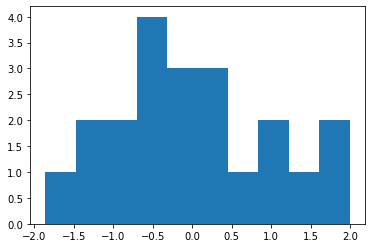

In [69]:
plt.hist((residuals[:,0,1]-np.mean(residuals[:,0,1]))/np.std(residuals[:,0,1]))

In [70]:
import itertools

train_df_nona_orig = train_df_nona.copy()

all_types_data = {}

for i in range(1,3+1):

    for combo in itertools.combinations(factor_types, i):

        factor_names = [factor[0] for factor in combo]

        print(factor_names)

        factor_inds = []

        for factor in combo:
            factor_inds.extend(factor[1])

        train_df_nona = train_df_nona_orig[factor_inds]

        all_model_data = []

        models = [
            ("Linear Regression", LinearRegression()),
            ("Lasso Regression", Lasso(alpha=0.1)),
            ("Ridge Regression", Ridge(alpha=0.1)),
            ("Random Forest Regressor (10)", RandomForestRegressor(n_estimators=10, max_depth=10)),
            ("Random Forest Regressor (100)", RandomForestRegressor(n_estimators=100, max_depth=10)),
            ("Random Forest Regressor (1000)", RandomForestRegressor(n_estimators=1000, max_depth=10)),
            # ("Logistic Regression", LogisticRegression()),
            # ("Lasso Logistic Regression", LogisticRegression(penalty="l1")),
            # ("Ridge Logistic Regression", LogisticRegression(penalty="l2")),
            # ("Random Forest Classifier (10)", RandomForestClassifier(n_estimators=10, max_depth=10)),
            # ("Random Forest Classifier (100)", RandomForestClassifier(n_estimators=100, max_depth=10)),
            # ("Random Forest Classifier (1000)", RandomForestClassifier(n_estimators=1000, max_depth=10)),
            ("Polynomial Regression (2)", make_pipeline(PolynomialFeatures(2), LinearRegression())),
            ("Polynomial Regression (3)", make_pipeline(PolynomialFeatures(3), LinearRegression())),
            ("Polynomial Lasso Regression (2)", make_pipeline(PolynomialFeatures(2), Lasso())),
            ("Polynomial Lasso Regression (3)", make_pipeline(PolynomialFeatures(3), Lasso()))
        ]

        for name, model in models:
            model_data = {}

            model_data["name"] = name

            model.fit(train_df_nona, train_y.loc[train_df_nona.index, :])
            model_data["R^2"] = model.score(train_df_nona, train_y.loc[train_df_nona.index, :])
            try:
                model_data["Adjusted R^2"] = 1 - (1-model["R^2"])*(len(train_df_nona)-1)/(len(train_df_nona)-len(model.coef_)-1)
            except:
                model_data["Adjusted R^2"] = 0

            model_data["CV Scores"] = cross_val_score(model, train_df_nona, train_y.loc[train_df_nona.index, :], cv=3)

            kf = KFold(n_splits=len(train_df_nona))

            residuals = []

            for train_index, test_index in kf.split(train_df_nona):
                model.fit(train_df_nona.iloc[train_index, :], train_y.iloc[train_index, :])
                residuals.append(model.predict(train_df_nona.iloc[test_index, :]) - train_y.iloc[test_index, :])

            residuals = np.array(residuals)

            model_data["residuals"] = residuals

            model_data["Seat Share Residual Mean"] = np.mean(residuals, axis=0)[:,0]
            model_data["Seat Share Residual Std"] = np.std(residuals, axis=0)[:,0]

            model_data["Vote Share Residual Mean"] = np.mean(residuals, axis=0)[:,1]
            model_data["Vote Share Residual Std"] = np.std(residuals, axis=0)[:,1]

            model.fit(train_df_nona[:-1], train_y.loc[train_df_nona[:-1].index, :])
            model_data["2020 Predicted Seat Share"] = model.predict(train_df_nona[-1:])[0][0]
            model_data["2020 Predicted Vote Share"] = model.predict(train_df_nona[-1:])[0][1]
            model_data["2020 Seat Share Error"] = model_data["2020 Predicted Seat Share"] - train_y.loc[train_df_nona.index[-1], "RepSeatShare"]
            model_data["2020 Vote Share Error"] = model_data["2020 Predicted Vote Share"] - train_y.loc[train_df_nona.index[-1], "RepVoteShare"]

            model.fit(train_df_nona, train_y.loc[train_df_nona.index, :])

            model_data["model"] = model

            all_model_data.append(model_data)

        all_types_data[tuple(factor_names)] = all_model_data

['Incumbent Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.428e-05, tolerance: 7.954e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-05, tolerance: 1.895e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Economic Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.743e-03, tolerance: 7.954e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.267e-03, tolerance: 6.092e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Polling Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.225e-06, tolerance: 2.424e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-03, tolerance: 7.954e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Incumbent Factors', 'Economic Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-04, tolerance: 2.424e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.459e-04, tolerance: 5.586e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Incumbent Factors', 'Polling Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.230e-03, tolerance: 7.954e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e-04, tolerance: 1.895e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Economic Factors', 'Polling Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-05, tolerance: 5.406e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-05, tolerance: 5.583e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

['Incumbent Factors', 'Economic Factors', 'Polling Factors']


/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.209e-04, tolerance: 7.954e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-05, tolerance: 1.895e-06
  model = cd_fast.enet_coordinate_descent(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

In [71]:
import pickle

pickle.dump(all_types_data, open("all_types_data.p", "wb"))

In [71]:
train_df_nona = train_df_nona_orig.copy()

In [73]:
train_df_nona.to_csv("train_df_nona.csv")
train_y.to_csv("train_y.csv")

In [73]:
all_types_data

{('Incumbent Factors',
  'Economic Factors',
  'Polling Factors'): [{'name': 'Linear Regression',
   'R^2': 0.9681443064777009,
   'Adjusted R^2': 0,
   'CV Scores': array([-240.07586988,   -3.82854943,   -2.22217343]),
   'Seat Share Residual Mean': array([-0.01833894]),
   'Seat Share Residual Std': array([0.16171593]),
   'Vote Share Residual Mean': array([-0.01147936]),
   'Vote Share Residual Std': array([0.07745038]),
   '2020 Predicted Seat Share': 0.4185288943356955,
   '2020 Predicted Vote Share': 0.40609583309201636,
   '2020 Seat Share Error': -0.07112627807809757,
   '2020 Vote Share Error': -0.08133196023288825,
   'model': LinearRegression()}, {'name': 'Lasso Regression',
   'R^2': 0.3624444880981638,
   'Adjusted R^2': 0,
   'CV Scores': array([-23.01198633,  -4.22348342,   0.04777647]),
   'Seat Share Residual Mean': array([0.0010535]),
   'Seat Share Residual Std': array([0.046667]),
   'Vote Share Residual Mean': array([0.00080872]),
   'Vote Share Residual Std': arra

In [67]:
all_model_data = all_types_data[("Incumbent Factors", "Economic Factors", "Polling Factors")]

models_df = pd.DataFrame(all_model_data)

In [68]:
pd.DataFrame(all_model_data).to_csv("all_model_data.csv")

In [69]:
train_df[-1:]

,year,is_midterm_year,rep_pres,RepSeatShare_prior,RepVoteShare_prior,absolute_sentiment,sentiment_change,absolute_gdp,gdp_change,rdi,rdi_change,annual_poll_approval,two_month_poll_approval,annual_poll_disapproval,two_month_poll_disapproval,annual_dem,two_month_dem,annual_rep,two_month_rep
36,2020,0,True,0.462069,0.45717,76.9,-14.3,3.9,-0.007193,0.026635,0.026635,44.8125,44.75,52.15625,53.75,48.230769,50.272727,40.641026,42.181818


In [70]:
pd.to_datetime(pd.read_csv("lite_data/approval_polllist.csv")["startdate"]).dt.year == 2022

0       False
1       False
2       False
3       False
4       False
        ...  
5150     True
5151     True
5152     True
5153     True
5154     True
Name: startdate, Length: 5155, dtype: bool

In [75]:
data_2022 = train_df[-1:].copy(deep=True)
data_2022["year"] = 2022
data_2022["is_midterm_year"] = 1
data_2022["rep_pres"] = False
data_2022["RepSeatShare_prior"] = train_y[-1:]["RepSeatShare"]
data_2022["RepVoteShare_prior"] = train_y[-1:]["RepVoteShare"]
data_2022["absolute_sentiment"] = sentiment_data[-1]
data_2022["sentiment_change"] = sentiment_data[-1] - sentiment_data[(sentiment_data.index.year == 2021) & sentiment_data.index.month == 1].mean()
data_2022["absolute_gdp"] = gdp_data[-1]
data_2022["gdp_change"] = gdp_data.pct_change(5)[-1]
data_2022["rdi"] = rdi_data[-1]
data_2022["rdi_change"] = rdi_data.pct_change(20)[-1]

biden_approval_538 = pd.read_csv("lite_data/approval_polllist.csv")
biden_approval_538["startdate"] = pd.to_datetime(biden_approval_538["startdate"])

data_2022["annual_poll_approval"] = biden_approval_538[biden_approval_538["startdate"].dt.year == 2022]["approve"].mean()
data_2022["two_month_poll_approval"] = pd.read_csv("lite_data/approval_topline.csv")["approve_estimate"].iloc[0]

data_2022["annual_poll_disapproval"] = biden_approval_538[biden_approval_538["startdate"].dt.year == 2022]["disapprove"].mean()
data_2022["two_month_poll_disapproval"] = pd.read_csv("lite_data/approval_topline.csv")["disapprove_estimate"].iloc[0]

generic_538 = pd.read_csv("lite_data/generic_polllist.csv")
generic_538["startdate"] = pd.to_datetime(generic_538["startdate"])

data_2022["annual_dem"] = generic_538[generic_538["startdate"].dt.year == 2022]["dem"].mean()
data_2022["annual_rep"] = generic_538[generic_538["startdate"].dt.year == 2022]["rep"].mean()

data_2022["two_month_dem"] = pd.read_csv("lite_data/generic_ballot_averages.csv")["pct_estimate"].iloc[-2]
data_2022["two_month_rep"] = pd.read_csv("lite_data/generic_ballot_averages.csv")["pct_estimate"].iloc[-1]

In [76]:
data_2022.to_csv("data_2022.csv")

In [81]:
models_df.loc[models_df["2020 Seat Share Error"].abs().argmin(), "model"].predict(data_2022)

array([[0.51832084, 0.5048066 ]])

In [82]:
models_df.loc[5, "model"].predict(data_2022)

array([[0.51832084, 0.5048066 ]])

In [74]:
predictions = [
    {"seat_share": models_df.loc[5, "model"].estimators_[i].predict(data_2022)[0][0], 
    "vote_share": models_df.loc[5, "model"].estimators_[i].predict(data_2022)[0][1]} 
    for i in range(len(models_df.loc[5, "model"].estimators_))
]

/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/joshuadoolan/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/joshuadoolan/opt/anaconda3/l

In [75]:
pd.DataFrame(predictions).quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])

,seat_share,vote_share
0.05,0.409195,0.444394
0.10,0.409195,0.457170
0.25,0.489655,0.487428
0.50,0.537931,0.507205
0.75,0.555819,0.529084
0.90,0.565517,0.534744
0.95,0.565517,0.535956


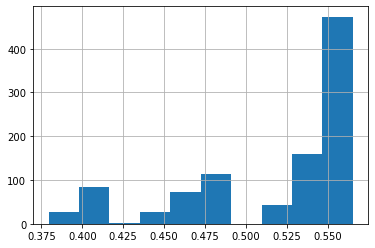

In [76]:
pd.DataFrame(predictions)["seat_share"].hist()
plt.savefig("seat_share_hist.png")

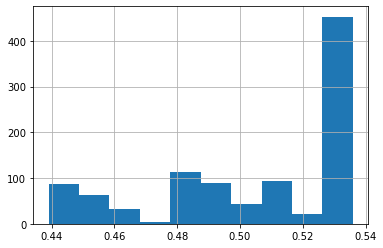

In [77]:
pd.DataFrame(predictions)["vote_share"].hist()